In [1]:
# modules
import os
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import dask
import dask.array
from scipy import ndimage
from skimage import filters, feature, io
from skimage.morphology import disk,ball
import sys
from itertools import combinations_with_replacement
import pickle
import imageio
import json
from dask.distributed import Client, LocalCluster
import socket
import subprocess
import gc
import h5py
import logging
import warnings
warnings.filterwarnings('ignore')


from dask import config as cfg
# cfg.set({'distributed.scheduler.worker-ttl': None, # Workaround so that dask does not kill workers while they are busy fetching data: https://dask.discourse.group/t/dask-workers-killed-because-of-heartbeat-fail/856, maybe this helps: https://www.youtube.com/watch?v=vF2VItVU5zg?
#         'distributed.scheduler.transition-log-length': 100, #potential workaround for ballooning scheduler memory https://baumgartner.io/posts/how-to-reduce-memory-usage-of-dask-scheduler/
#          'distributed.scheduler.events-log-length': 100
#         }) seems to be outdate

cfg.set({'distributed.scheduler.worker-ttl': None, # Workaround so that dask does not kill workers while they are busy fetching data: https://dask.discourse.group/t/dask-workers-killed-because-of-heartbeat-fail/856, maybe this helps: https://www.youtube.com/watch?v=vF2VItVU5zg?
        'distributed.admin.low-level-log-length': 100 #potential workaround for ballooning scheduler memory https://baumgartner.io/posts/how-to-reduce-memory-usage-of-dask-scheduler/
        }) # still relevant ?

#paths
host = socket.gethostname()
if host == 'mpc2959.psi.ch':
    temppath = '/mnt/SSD/fische_r/tmp'
    training_path =  '/mnt/SSD/fische_r/Tomcat_2/'
    pytrainpath = '/mpc/homes/fische_r/lib/pytrainseg'
    # memlim = '840GB'
    memlim = '440GB'
    # memlim = '920GB'
elif host[:3] == 'ra-':
    temppath = '/das/home/fische_r/interlaces/Tomcat_2/tmp'
    training_path = '/das/home/fische_r/interlaces/Tomcat_2'
    pytrainpath = '/das/home/fische_r/lib/pytrainseg'
    memlim = '220GB'
else:
    print('host '+host+' currently not supported')
    
# get the ML functions, TODO: make a library once it works/is in a stable state

cwd = os.getcwd()
os.chdir(pytrainpath)
from V2_feature_stack import image_filter
import V2_training as tfs
from V2_training import training

pytrain_git_sha = subprocess.check_output(['git', 'rev-parse', '--short', 'HEAD']).decode().strip()
os.chdir(cwd)



### functionalities for interactive training

In [53]:
from ipywidgets import Image
from ipywidgets import ColorPicker, IntSlider, link, AppLayout, HBox
from ipycanvas import  hold_canvas,  MultiCanvas #RoughCanvas,Canvas,

def on_mouse_down(x, y):
    global drawing
    global position
    global shape
    drawing = True
    position = (x, y)
    shape = [position]

def on_mouse_move(x, y):
    global drawing
    global position
    global shape
    if not drawing:
        return
    with hold_canvas():
        canvas.stroke_line(position[0], position[1], x, y)
        position = (x, y)
    shape.append(position)

def on_mouse_up(x, y, fill=False):
    global drawing
    global positiondu
    global shape
    drawing = False
    with hold_canvas():
        canvas.stroke_line(position[0], position[1], x, y)
        if fill:
            canvas.fill_polygon(shape)
    shape = []
    
def display_feature(i, TS, feat_stack):
    # print('selected '+TS.feature_names[i])
    im = feat_stack[:,:,i]
    im8 = im-im.min()
    im8 = im8/im8.max()*255
    return im8

### fire up dask, distributed Client currently not usable. No idea how not setting up dask affects the computation

In [3]:
dask.config.config['temporary-directory'] = temppath
def boot_client(dashboard_address=':35000', memory_limit = memlim, n_workers=2): # 2 workers appears to be the optimum, will still distribute over the full machine
    tempfolder = temppath  #a big SSD is a major adavantage to allow spill to disk and still be efficient. large dataset might crash with too small SSD or be slow with normal HDD
# tempfolder = temppath_2
# dask.config.config['distributed']['worker']['memory']['recent-to-old-time'] = '200000s'

# here you have the option to use a virtual cluster or even slurm on ra (not attempted yet)
    cluster = LocalCluster(dashboard_address=dashboard_address, memory_limit = memory_limit, n_workers=n_workers, silence_logs=logging.ERROR) #settings optimised for mpc2959, play around if needed, if you know nothing else is using RAM then you can almost go to the limit
# # maybe less workers with more threads makes better use of shared memory 

# # scheduler_port = 'tcp://129.129.188.222:8786' #<-- if scheduler on mpc2959; scheduler on mpc2053 -> 'tcp://129.129.188.248:8786'
# # cluster = scheduler_port

    client = Client(cluster) #don't show warnings, too many seem to block execution
# # client.amm.start()
    print('Dashboard at '+client.dashboard_link)
    return client, cluster

def reboot_client(client, dashboard_address=':35000', memory_limit = memlim, n_workers=2):
    client.shutdown()
    cluster = LocalCluster(dashboard_address=dashboard_address, memory_limit = memory_limit, n_workers=n_workers, silence_logs=logging.ERROR)
    client = Client(cluster)
    return client

In [4]:
client, cluster = boot_client()

Dashboard at http://127.0.0.1:35000/status


## Data preparation

### let dask load the data

store data in a hdf5 (eg. xarray to .nc) as an entry 'image_data' containing a 4D array. There is potential in structuring the data on the disk (SSD recommended for fast data streaming)

In [5]:
sample = 'R_m7_33_200_1_II'
imagepath = os.path.join(training_path, '01_'+sample+'_cropped.nc')

In [6]:
file = h5py.File(imagepath)

In [7]:
chunk_space = 36 # potential for optmisation by matching chunksize with planned image filter kernels and file structure on disk for fast data streaming
chunks = (chunk_space,chunk_space,chunk_space,len(file['time']))
da = dask.array.from_array(file['image_data'], chunks= chunks)

### get data into image filter class

In [8]:
# TODO: include this routine into pytrainseg

IF = image_filter(sigmas = [0,1,3,6]) 
IF.data = da
shp = da.shape

### prepare features
creates a dask graph with dependent calculations to allow on-demand and larger-than-memory calculation

In [9]:
IF.prepare()

In [10]:
IF.stack_features()

In [11]:
IF.feature_stack

dask.array<stack, shape=(700, 330, 2016, 100, 105), dtype=float64, chunksize=(36, 36, 36, 100, 1), chunktype=numpy.ndarray>

In [12]:
IF.make_xarray()

using full feature stack because
- reduced stack not calculated


## Training

### set up some objects

In [13]:
training_path_sample = os.path.join(training_path, sample)
if not os.path.exists(training_path_sample):
    os.mkdir(training_path_sample)

In [14]:
TS = training(training_path=training_path_sample)
TS.client = client
IF.client = client
TS.cluster = cluster
IF.cluster = cluster
TS.memlim = memlim
TS.n_workers = 2

There are existing training sets, run .train() if you want to use them:
label_image_z_200_time_80_.tif
label_image_z_42_time_30_.tif


### give the feature stack to the training class

In [15]:
TS.feat_data = IF.feature_xarray

In [16]:
IF.combined_feature_names = list(IF.feature_names) + list(IF.feature_names_time_independent)
TS.combined_feature_names = IF.combined_feature_names

In [17]:
TS.combined_feature_names 

['Gaussian_4D_Blur_0.0',
 'Gaussian_4D_Blur_1.0',
 'Gaussian_4D_Blur_3.0',
 'Gaussian_4D_Blur_6.0',
 'Gaussian_4D_Blur_2.0',
 'diff_of_gauss_4D_1.0_0.0',
 'diff_of_gauss_4D_3.0_0.0',
 'diff_of_gauss_4D_6.0_0.0',
 'diff_of_gauss_4D_2.0_0.0',
 'diff_of_gauss_4D_3.0_1.0',
 'diff_of_gauss_4D_6.0_1.0',
 'diff_of_gauss_4D_2.0_1.0',
 'diff_of_gauss_4D_6.0_3.0',
 'diff_of_gauss_4D_2.0_3.0',
 'diff_of_gauss_4D_2.0_6.0',
 'Gradient_sigma_1.0_0',
 'Gradient_sigma_1.0_1',
 'Gradient_sigma_1.0_2',
 'Gradient_sigma_1.0_3',
 'hessian_sigma_1.0_00',
 'hessian_sigma_1.0_01',
 'hessian_sigma_1.0_02',
 'hessian_sigma_1.0_03',
 'hessian_sigma_1.0_11',
 'hessian_sigma_1.0_12',
 'hessian_sigma_1.0_13',
 'hessian_sigma_1.0_22',
 'hessian_sigma_1.0_23',
 'hessian_sigma_1.0_33',
 'Gradient_sigma_3.0_0',
 'Gradient_sigma_3.0_1',
 'Gradient_sigma_3.0_2',
 'Gradient_sigma_3.0_3',
 'hessian_sigma_3.0_00',
 'hessian_sigma_3.0_01',
 'hessian_sigma_3.0_02',
 'hessian_sigma_3.0_03',
 'hessian_sigma_3.0_11',
 'hessian_

### interactive training

#### check for existing training sets

In [18]:
existing_sets = os.listdir(os.path.join(training_path_sample, 'label_images'))
existing_sets.sort()
existing_sets

['label_image_z_200_time_80_.tif', 'label_image_z_42_time_30_.tif']

In [19]:
TS.training_dict = {}

#### re-train with existing label sets. clear the training dictionary if necessary (training_dict)
don't use this if you already have a pickled training_dict

In [20]:
TS.train()

training with existing label images
label_image_z_42_time_30_.tif
label_image_z_200_time_80_.tif


#### import training dict of other samples 
(replace sample name and repeat for multiple samples), if necessary check features for overlap

In [21]:
# TODO: make better naming convention below when pickling the training_dict

# oldsample = '4'
# oldgitsha = 'e42ad75' #'109a7ce3' #retrain at one point
# # if oldsample == '4':
# #     training_dict_old = pickle.load(open(os.path.join(toppathSSD, '05_water_GDL_ML', '4', 'ec4415d_training_dict_without_loc_feat.p'), 'rb'))
# # else:
# training_dict_old = pickle.load(open(os.path.join(training_path, oldsample,  oldgitsha+'_training_dict.p'),'rb'))
# oldfeatures = pickle.load(open(os.path.join(training_path, oldsample,  oldgitsha+'_feature_names.p'),'rb'))
    
#     # pickle.dump(TS.training_dict, open(os.path.join(TS.training_path, pytrain_git_sha+'_training_dict.p'),'wb'))
# # pickle.dump(TS.feature_names, open(os.path.join(TS.training_path, pytrain_git_sha+'_feature_names.p'),'wb'))

# for key in training_dict_old.keys():
#     TS.training_dict[oldsample+key] = training_dict_old[key]

#### suggest a new training coordinate
currently retraining with new feature stack not properly implemented. Workaround: choose from the exiting training sets and train with them (additional labeling optional)

In [107]:
TS.suggest_training_set()

You could try  z = 1589  at time step  1


In [109]:
c1 = 'z'
p1 = 1200
c2 = 'time'  # c2 has always to be time currently . Removed option to chose two spatial coordinates because was not useful, but left syntax to keep the potential to add it again in the future
p2 = 82

### activate the training set and load label images if existent

In [110]:
TS.load_training_set(c1, p1, c2, p2)

In [111]:
# reboot the dask client if it lost a worker
if not len(client.cluster.workers)>1:   
    client = reboot_client(client)
    TS.client = client
    IF.client = client

In [112]:
#  TODO: move  the routine into training class
# TODO: add if clause to not do anything if the coordinates did not change and the stack has already been calcualted

feat_data = TS.feat_data
[c1,p1,c2,p2] = TS.current_coordinates
newslice = True

if c1 == 'x' and c2 == 'time':
    feat_stack = feat_data['feature_stack'].sel(x = p1, time = p2)
    feat_stack_t_idp = feat_data['feature_stack_time_independent'].sel(x = p1, time_0 = 0)
# elif c1 == 'x' and c2 == 'y':
#     feat_stack = feat_data['feature_stack'].sel(x = p1, y = p2)#.data
#     feat_stack_t_idp = feat_data['feature_stack_time_independent'].sel(x = p1, y = p2)
# elif c1 == 'x' and c2 == 'z':
#     feat_stack = feat_data['feature_stack'].sel(x = p1, z = p2)#.data
#     feat_stack_t_idp = feat_data['feature_stack_time_independent'].sel(x = p1, z = p2)
# elif c1 == 'y' and c2 == 'z':
#     feat_stack = feat_data['feature_stack'].sel(y = p1, z = p2)#.data
#     feat_stack_t_idp = feat_data['feature_stack_time_independent'].sel(y = p1, z = p2)
elif c1 == 'y' and c2 == 'time':
    feat_stack = feat_data['feature_stack'].sel(y = p1, time = p2)#.data
    feat_stack_t_idp = feat_data['feature_stack_time_independent'].sel(y = p1, time_0 = 0)
elif c1 == 'z' and c2 == 'time':
    feat_stack = feat_data['feature_stack'].sel(z = p1, time = p2)#.data
    feat_stack_t_idp = feat_data['feature_stack_time_independent'].sel(z = p1, time_0 = 0)

### calculate the feature stack for the selected slice

#### time dependent features

In [113]:
#  TODO: move into training class and keep up to date with dask development for the best way to do this
# watch the dashboard for some colorful process tracing, having a eye on the "workers" can help to deal with memory issues
if type(feat_stack) is not np.ndarray:
        fut = client.scatter(feat_stack)
        fut = fut.result()
        fut = fut.compute()
        feat_stack = fut
        try:
            # restart dask client to wipe leaked memory
            client.restart()
        except:
            # do a full reboot if this fails
            client = reboot_client(client)
            TS.client = client
            IF.client = client   

#### check if the cluster survived the calculation

In [114]:
# needs to stay to be interactive
client.cluster.workers

{0: <Nanny: tcp://127.0.0.1:40851, threads: 28>,
 1: <Nanny: tcp://127.0.0.1:36269, threads: 28>}

#### time independent features

In [115]:
# move into training class at one pointl
if type(feat_stack_t_idp) is not np.ndarray:
        fut = client.scatter(feat_stack_t_idp)
        fut = fut.result()
        fut = fut.compute()
        feat_stack_t_idp = fut
        try:
            client.restart()
        except:
            client = reboot_client(client)
            TS.client = client
            IF.client = client   

#### check if the cluster survived the calculation

In [116]:
# needs to stay to be interactive
client.cluster.workers

{0: <Nanny: tcp://127.0.0.1:42561, threads: 28>,
 1: <Nanny: tcp://127.0.0.1:43545, threads: 28>}

In [120]:
print('I am back from calculating and have still '+str(len(client.cluster.workers))+' workers')

I am back from calculating and have still 2 workers


#### merge the two feature stacks

In [121]:
# needs to stay to be interactive
# feat_stack_full = np.concatenate([feat_stack, feat_stack_t_idp], axis = 2)
feat_stack = np.concatenate([feat_stack, feat_stack_t_idp], axis = 2) #this line to save a bit RAM

In [122]:
feat_stack.shape

(700, 330, 110)

In [123]:
# this necessary ??
# TS.current_feat_stack_full = feat_stack_full
TS.current_feat_stack_full = feat_stack
if type(TS.current_feat_stack_full) is not np.ndarray:
    TS.current_computed = False
else:
    TS.current_computed = True

In [124]:
TS.current_feat_stack_full.shape

(700, 330, 110)

### canvas for labeling and training

#### give index of feature in case you want to use it for training
can be very useful to for example label static components

In [125]:
i  = 74
print(i, IF.combined_feature_names[i])

74 Gaussian_time_6.0


In [126]:
im8 = TS.current_im8 # execute this line to get the orignal display

#### set up the canvas

In [132]:
# move to training class at low prio
# needs interactive buttons if the code is hidden in class
# button for color and alpha
# for now, leave exposed

alpha = 0.15 #transparance

## in case you want to zoom, but it works better if you pan (not zoom) in the browser. panning can be done with the trackpad of a laptop, but there is also some key combinations TODO lock up
# zoom1 = (-500,-1)
# zoom2 = (600,1400)
# zoom1 = (0, -1)
# zoom2 = (0, -1)
#trick: use gaussian_time_4_0 to label static phases ()
# im8 = display_feature(104, TS, feat_stack)

# print(IF.combined_feature_names[-20])
print('original shape: ',im8.shape)
im8_display = im8.copy() #[zoom1[0]:zoom1[1], zoom2[0]:zoom2[1]]
# print('diyplay shape : ',im8_display.shape,' at: ', (zoom1[0], zoom2[0]))

resultim = TS.current_result.copy()
resultim_display = resultim #[zoom1[0]:zoom1[1], zoom2[0]:zoom2[1]]


width = im8_display.shape[1]
height = im8_display.shape[0]
Mcanvas = MultiCanvas(4, width=width, height=height)
background = Mcanvas[0]
resultdisplay = Mcanvas[2]
truthdisplay = Mcanvas[1]
canvas = Mcanvas[3]
canvas.sync_image_data = True
drawing = False
position = None
shape = []
image_data = np.stack((im8_display, im8_display, im8_display), axis=2)
background.put_image_data(image_data, 0, 0)
slidealpha = IntSlider(description="Result overlay", value=0.15)
resultdisplay.global_alpha = alpha #slidealpha.value
if np.any(resultim>0):
    result_data = np.stack(((resultim_display==0), (resultim_display==1),(resultim_display==2)), axis=2)*255
    mask3 = resultim_display==3
    result_data[mask3,0] = 255
    result_data[mask3,1] = 255
else:
    result_data = np.stack((0*resultim, 0*resultim, 0*resultim), axis=2)
resultdisplay.put_image_data(result_data, 0, 0)
canvas.on_mouse_down(on_mouse_down)
canvas.on_mouse_move(on_mouse_move)
canvas.on_mouse_up(on_mouse_up)
picker = ColorPicker(description="Color:", value="#ff0000") #red
# picker = ColorPicker(description="Color:", value="#0000ff") #blue
# picker = ColorPicker(description="Color:", value="#00ff00") #green
# picker = ColorPicker(description="Color:", value="#ffff00") #yellow
### all currently supported color options. -> gives the possibility to label 4 different phases

link((picker, "value"), (canvas, "stroke_style"))
link((picker, "value"), (canvas, "fill_style"))
link((slidealpha, "value"), (resultdisplay, "global_alpha"))

HBox((Mcanvas,picker))
# HBox((Mcanvas,)) #picker 

original shape:  (700, 330)


#### adjust grayscale range of the display of the image by playing with the lines below
has no effect on the data. If you mess up, there are some lines at beggining of the canvas cell to get the previous display back

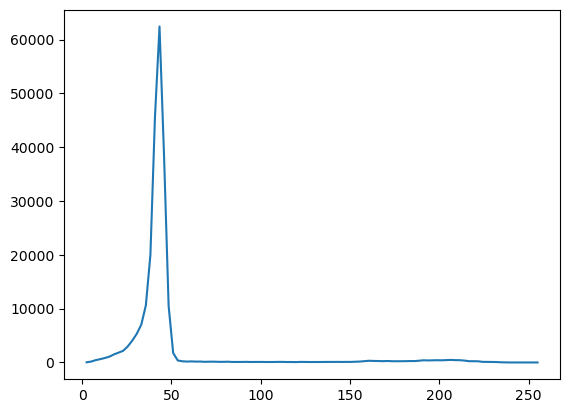

In [133]:
tfs.display.plot_im_histogram(im8)
# im8 = TS.current_im8 # uncomment this line to get the original back display (raw at original grayscale range)
# im8 = tfs.display.adjust_image_contrast(im8,0,100)

#### update training set if labels are ok or clear the current canvas by re-running the cell above if not
automatically updates the stored label image on the disk

In [134]:
# same as above

label_set = canvas.get_image_data()

test = TS.current_truth.copy()

test[np.bitwise_and(label_set[:,:,0]>0,np.bitwise_xor(label_set[:,:,0]>0,label_set[:,:,1]>0))] = 1
test[label_set[:,:,1]>0] = 2
test[label_set[:,:,2]>0] = 4 #order of 4&3 flipped for legacy reasons (existing training labels)
test[np.bitwise_and(label_set[:,:,0]>0,label_set[:,:,1]>0)] = 3

TS.current_truth = test.copy()
imageio.imsave(TS.current_truthpath, TS.current_truth)

#### inspect labels and training progress
can be sometimes useful

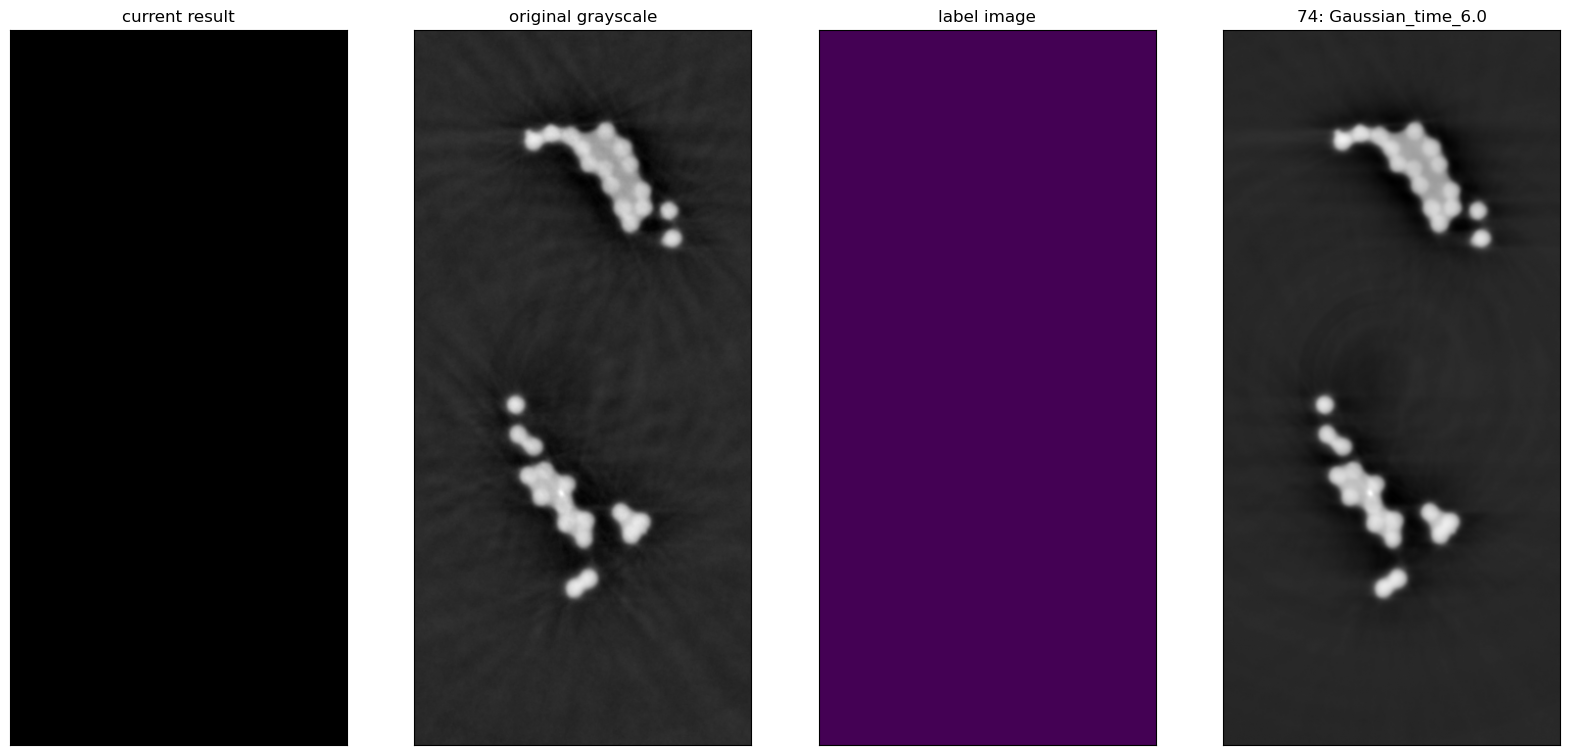

In [135]:
# same as above

fig, axes = plt.subplots(1,4, figsize=(20,10))
axes[0].imshow(TS.current_result, 'gray')
axes[0].set_title('current result')
axes[1].imshow(TS.current_im8, 'gray')
axes[1].set_title('original grayscale')

# TS.current_diff_im = TS.current_im-TS.current_first_im
# TS.current_diff_im = TS.current_diff_im/TS.current_diff_im.max()*255
# axes[2].imshow(-TS.current_diff_im)#,vmin=6e4)
# axes[3].imshow(im8old, 'gray')
# axes[3].imshow(TS.current_first_im, 'gray')
axes[2].imshow(TS.current_truth)
axes[2].set_title('label image')
if TS.current_computed:
    axes[3].imshow(TS.current_feat_stack_full[:,:,i], 'gray')
    axes[3].set_title(str(i)+': '+IF.combined_feature_names[i])
else:
    axes[3].imshow(TS.current_result, 'gray')
    axes[3].set_title('current result')
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

#### train!

In [136]:
TS.train_slice()

training and classifying


#### revise feature importance to decide on omiting a few to make calculation more efficient
TODO implementation to be done

Text(0, 0.5, 'importance')

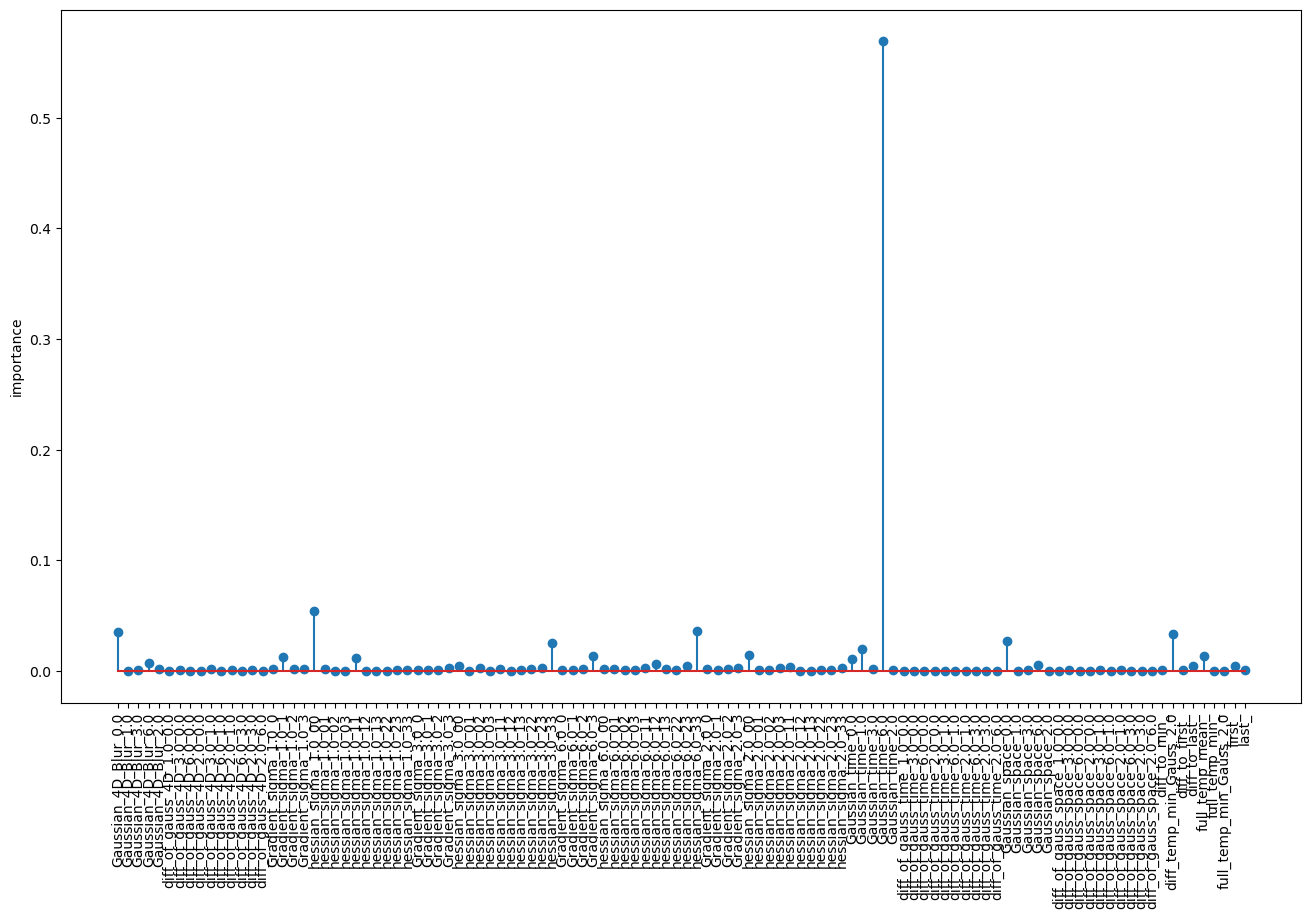

In [137]:
plt.figure(figsize=(16,9))
plt.stem(IF.combined_feature_names, TS.clf.feature_importances_,'x')
plt.xticks(rotation=90)
plt.ylabel('importance') 

In [140]:
pickle.dump(TS.training_dict, open(os.path.join(training_path, pytrain_git_sha+'_training_dict.p'),'wb'))
pickle.dump(TS.combined_feature_names, open(os.path.join(training_path, pytrain_git_sha+'_feature_names.p'),'wb'))

In [139]:
training_path

'/das/home/fische_r/interlaces/Tomcat_2'